### Zadanie 1 (1p)

Porównać w języku Julia reprezentację bitową liczby 1/3 dla `Float16`, `Float32`, `Float64` oraz liczby, 
która jest inicjalizowana jako `Float16`, a potem rzutowana na `Float64`.

### Zadanie 2 (2p)

Zbadać, jak zmienia się odległość między kolejnymi liczbami zminnoprzecinkowymi 
reprezentowanymi w komputerze za pomocą języka Julia. 
Narysować wykres używając Plots zależności odległości od wartości liczby dla zakresu  od 1.0 do 1000000.0.

### Zadanie 3 (2p)

Jedną z bibliotek numerycznych, jaką dodatkowo będziemy używać na zajęciach jest <a href="http://www.gnu.org/software/gsl/gsl.html">GSL</a> (język C). Opis <a href="https://www.gnu.org/software/gsl/doc/html/usage.html"> jak używać </a>. Korzystając ze <a href="https://www.gnu.org/software/gsl/doc/html/ieee754.html"> wsparcia dla wyświetlania reprezentacji liczb zmiennoprzecinkowych</a> zobaczyć jak zmienia się cecha i mantysa dla coraz mniejszych liczb. Zaobserwować, kiedy matysa przestaje być znormalizowana i dlaczego?

Kod załączyć jako komórka Markdown sformatowana jako C ([link](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#code)). Wynik także jako Markdown (kod albo fragment zrzutu ekranu).

### Zadanie 4 (4p)

Na przykładzie wybranego algorytmu niestabilnego numerycznie: 
1. Pokazać, że działa źle.
2. Pokazać które konkretnie działania powodują zwiększenie błędu (np. dzielenie przez małą liczbę, cancellation).
3. Zademonstować wersję stabilną.

Nie wolno pokazywać przykładów z wykładu (lub bardzo podobnych)!

Wszystkie punkty przedstawić w postaci notatnika Julii.

In [1]:
bitstring(Float16(1/3))

"0011010101010101"

In [2]:
bitstring(Float32(1/3))

"00111110101010101010101010101011"

In [3]:
bitstring(Float64(1/3))

"0011111111010101010101010101010101010101010101010101010101010101"

In [4]:
bitstring(convert(Float64, Float16(1/3)))

"0011111111010101010101000000000000000000000000000000000000000000"

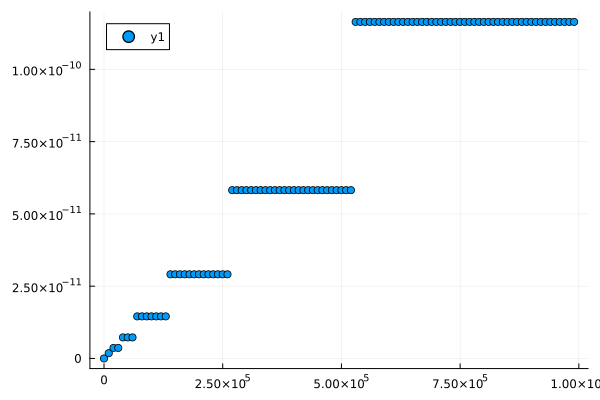

In [5]:
using Plots

tab = []
for i = 1.0:10000:1000000.0
    push!(tab, eps(i))
end

scatter(1:10000:1000000, tab)

Zadanie 3 - kod c:

```c
int main() {

    gsl_ieee_env_setup ();

    float a = 1e-33;
    for (int i = 0; i < 38; i++) {
        gsl_ieee_printf_float(&a);
        printf("\n");
        a /= 2.0;
    }

    return 0;
}
```

wyniki:

1.01001100010011101001100*2^-111
1.01001100010011101001100*2^-112
1.01001100010011101001100*2^-113
1.01001100010011101001100*2^-114
1.01001100010011101001100*2^-115
1.01001100010011101001100*2^-116
1.01001100010011101001100*2^-117
1.01001100010011101001100*2^-118
1.01001100010011101001100*2^-119
1.01001100010011101001100*2^-120
1.01001100010011101001100*2^-121
1.01001100010011101001100*2^-122
1.01001100010011101001100*2^-123
1.01001100010011101001100*2^-124
1.01001100010011101001100*2^-125
1.01001100010011101001100*2^-126
0.10100110001001110100110*2^-126
0.01010011000100111010011*2^-126
0.00101001100010011101010*2^-126
0.00010100110001001110101*2^-126
0.00001010011000100111010*2^-126
0.00000101001100010011101*2^-126
0.00000010100110001001110*2^-126
0.00000001010011000100111*2^-126
0.00000000101001100010100*2^-126
0.00000000010100110001010*2^-126
0.00000000001010011000101*2^-126
0.00000000000101001100010*2^-126
0.00000000000010100110001*2^-126
0.00000000000001010011000*2^-126
0.00000000000000101001100*2^-126
0.00000000000000010100110*2^-126
0.00000000000000001010011*2^-126
0.00000000000000000101010*2^-126
0.00000000000000000010101*2^-126
0.00000000000000000001010*2^-126
0.00000000000000000000101*2^-126
0.00000000000000000000010*2^-126
0.00000000000000000000001*2^-126
0


Zadanie 4 - żeby pokazać błędne działanie algorytmu niestabilnego numerycznie użyję algorytmu do wyliczania pierwiastków równania kwadratowego. Okazuje się on robić błedy gdy doprowadzimy do odejmowania bardzo podobnych do siebie liczb (przy wyliczaniu x1 bądź x2).

Weźmy przykładowe równanie kwadratowe:
ax^2 + bx + c = 0, 
gdzie:

In [6]:
a = 1
b = Float16(-5.479)
c = Float16(0.0058)

Float16(0.0058)

Na początku policzę rozwiązania równania przy użyciu wzoru na deltę i pierwiastki równania kwadratowego.

In [7]:
delta = b^2 - 4c
sqrtdelta = sqrt(delta)

println("pierwiastek z delty:  ", sqrtdelta)

x1 = (-b - sqrtdelta) / 2
x2 = (-b + sqrtdelta) / 2

println("x1: ", x1, "  x2: ", x2)

pierwiastek z delty:  5.48
x1: 0.0  x2: 5.48


Widać błąd przy obliczaniu x1. Mimo, że wyraźnie widać, że pierwiastek z delty wartością różni się od -b, x1 wyliczane jest jako 0. Wynika to z za małej dokładności reprezentacji liczb (brak kolejnych cyfr mantysy) - jest to tak zwany błąd cancellation: 

In [8]:
println(bitstring(-b))
println(bitstring(sqrtdelta))

0100010101111011
0100010101111011


Stabilne rozwiązanie tego problemu wygląda następująco:<br>
1) na początku sprawdzamy, czy b > 0.<br>
2) jeżeli tak, obliczamy x1 z tradycyjnego wzoru (jeżeli nie, to analogicznie obliczamy x2)<br>
3) obliczamy x2 używając wzoru Viete'a: x1 * x2 = c / a (analogicznie x1)<br>

W naszym przypadku b < 0, więc x2 obliczamy normalnie ze wzoru, a x1 ze wzoru Viete'a.


In [9]:
x1 = c / x2

Float16(0.001058)

W tym wypadku otrzymaliśmy wynik dużo bardziej prawdopodobny, pokrywa się on również z wyliczeniami kalkulatora.